<a href="https://colab.research.google.com/github/dduwa/ocular-disease-recognition/blob/main/VGG16_ODIR5K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
import os

from concurrent.futures import ThreadPoolExecutor

import seaborn as sns
from sklearn.metrics import confusion_matrix
import ast

# Access Dataset via Kaggle API
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem.

In [ ]:
from google.colab import files
uploaded = files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip

Saving kaggle.json to kaggle.json
 99% 1.60G/1.62G [00:08<00:00, 240MB/s]
100% 1.62G/1.62G [00:08<00:00, 211MB/s]


# Loading the Dataset

In [ ]:
df_data = pd.read_csv('full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Dataset Information

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# Splitting the Data

In [ ]:
print(type(df_data['target'].iloc[0]))


<class 'str'>


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training, test and validation sets
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

# Data Distribution
- Class imbalance, we have minority classes M, H, G, C, A.

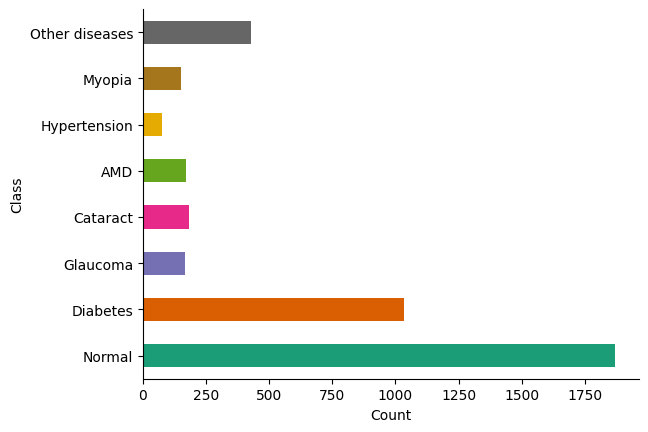

In [ ]:
# @title Distribution of Training Data
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
train_df['class_name'] = train_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = train_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

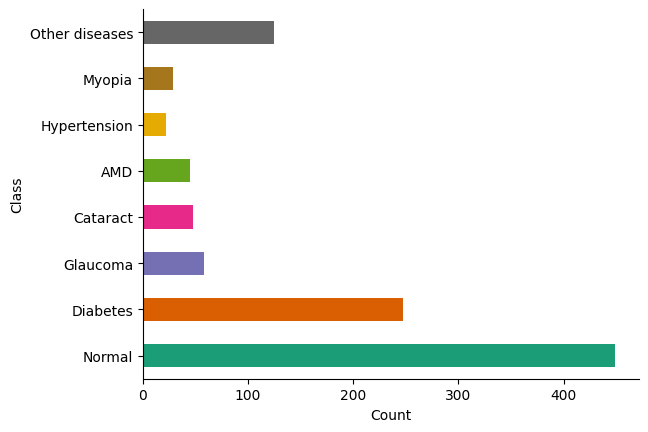

In [ ]:
# @title Distribution of Validation Data
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
val_df['class_name'] = val_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = val_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

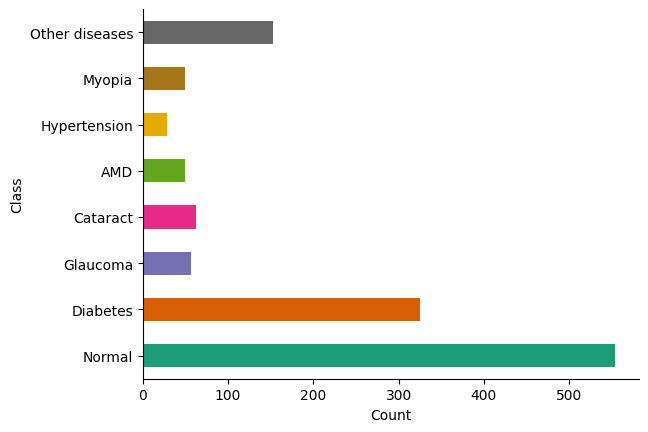

In [ ]:
# @title Distribution of Test Data
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
test_df['class_name'] = test_df['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = test_df['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

# Data Preparation

##Apply random sampling


In [ ]:
from sklearn.utils import resample

class_distribution = train_df['target'].value_counts()


# Set minimum and maximum thresholds
min_threshold = int(class_distribution.max() * 0.5)  # minimum is half of the largest class size
max_threshold = int(class_distribution.max() * 0.8)  # maximum is 80% of the largest class size

# Determine target samples per class based on conditions
n_samples_per_class = {
    label: max(min_threshold, min(len(df_class), max_threshold)) for label, df_class in train_df.groupby('target')
}

# Print out the values for sanity check
print("Number of samples per class to resample to:", n_samples_per_class)

# Initialize an empty DataFrame to hold the resampled data
df_resampled = pd.DataFrame(columns=train_df.columns)

# Upsample or downsample each class according to the specified logic
for class_label, target_count in n_samples_per_class.items():
    df_class = train_df[train_df['target'] == class_label]

    if not df_class.empty:
        # Resample each class to the target count
        df_class_resampled = resample(df_class,
                                      replace=len(df_class) < target_count,  # Sample with replacement if upsampling
                                      n_samples=target_count,  # Target count determined by the logic above
                                      random_state=123)  # For reproducibility
        df_resampled = pd.concat([df_resampled, df_class_resampled])
    else:
        print(f"No samples for class {class_label}. Check your data.")

# Shuffle the resampled DataFrame if necessary
df_resampled = df_resampled.sample(frac=1, random_state=123).reset_index(drop=True)


Number of samples per class to resample to: {'[0, 0, 0, 0, 0, 0, 0, 1]': 935, '[0, 0, 0, 0, 0, 0, 1, 0]': 935, '[0, 0, 0, 0, 0, 1, 0, 0]': 935, '[0, 0, 0, 0, 1, 0, 0, 0]': 935, '[0, 0, 0, 1, 0, 0, 0, 0]': 935, '[0, 0, 1, 0, 0, 0, 0, 0]': 935, '[0, 1, 0, 0, 0, 0, 0, 0]': 1036, '[1, 0, 0, 0, 0, 0, 0, 0]': 1496}


**Class distribution before sampling**

In [ ]:
# Assuming 'target' is the name of your target column
class_distribution = train_df['target'].value_counts()

# To see the distribution as percentages of the total
class_distribution_percentage = train_df['target'].value_counts(normalize=True) * 100

print("Class Distribution (Count):\n", class_distribution)


Class Distribution (Count):
 target
[1, 0, 0, 0, 0, 0, 0, 0]    1870
[0, 1, 0, 0, 0, 0, 0, 0]    1036
[0, 0, 0, 0, 0, 0, 0, 1]     430
[0, 0, 0, 1, 0, 0, 0, 0]     183
[0, 0, 0, 0, 1, 0, 0, 0]     171
[0, 0, 1, 0, 0, 0, 0, 0]     169
[0, 0, 0, 0, 0, 0, 1, 0]     153
[0, 0, 0, 0, 0, 1, 0, 0]      78
Name: count, dtype: int64


**Class Distribution after sampling**

In [ ]:
# Assuming 'target' is the name of your target column
class_distribution = df_resampled['target'].value_counts()

# To see the distribution as percentages of the total
class_distribution_percentage = df_resampled['target'].value_counts(normalize=True) * 100

print("Class Distribution (Count):\n", class_distribution)

Class Distribution (Count):
 target
[1, 0, 0, 0, 0, 0, 0, 0]    1496
[0, 1, 0, 0, 0, 0, 0, 0]    1036
[0, 0, 0, 0, 0, 0, 1, 0]     935
[0, 0, 0, 0, 0, 1, 0, 0]     935
[0, 0, 0, 0, 1, 0, 0, 0]     935
[0, 0, 0, 0, 0, 0, 0, 1]     935
[0, 0, 1, 0, 0, 0, 0, 0]     935
[0, 0, 0, 1, 0, 0, 0, 0]     935
Name: count, dtype: int64


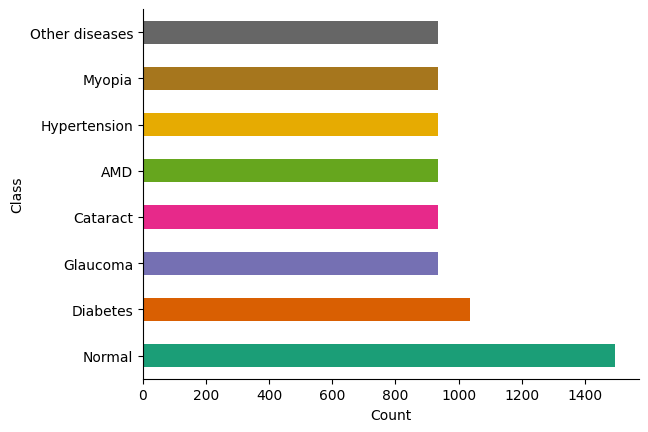

In [ ]:
# Define the class names
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Decode one-hot encoded labels to class names
df_resampled['class_name'] = df_resampled['target'].apply(lambda x: class_labels[ast.literal_eval(x).index(1)])


# Now we create a Series with the counts of each class name
class_counts = df_resampled['class_name'].value_counts().reindex(class_labels).fillna(0)

# Plot the distribution with class names in the same order as class_labels
class_counts.plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()

##Image Preprocessing

In [ ]:
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.vgg16.preprocess_input(image)  # Preprocessing the image to be compatible with vgg16
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

Preparing Augmented and Oversampled Training Dataset

In [ ]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
import tensorflow_addons as tfa

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # Random rotation
    angle = tf.random.uniform([], -0.2, 0.2)  # Random angle between -0.2 and 0.2 radians
    image = tfa.image.rotate(image, angles=angle)

    # Random zoom
    if tf.random.uniform([]) > 0.5:
        image = tf.image.central_crop(image, central_fraction=tf.random.uniform([], 0.8, 1.0))
        image = tf.image.resize(image, [224, 224])

    # Random hue adjustment for color
    image = tf.image.random_hue(image, max_delta=0.02)

    return image, label


Preparing Test and Validation Datasets

In [ ]:
def file_exists(file_paths):
    # Filter out non-existing files
    return [file_path for file_path in file_paths if os.path.exists(file_path)]

def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32, augment_data=False):
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Filter out filenames that do not exist
    valid_filenames = file_exists(filenames)
    valid_labels = labels[np.isin(filenames, valid_filenames)]  # Keep labels corresponding to the valid filenames

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((valid_filenames, valid_labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if augment_data:
        dataset = dataset.map(augment)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(valid_filenames))
    dataset = dataset.batch(batch_size)
    return dataset


In [ ]:
train_ds = load_and_prepare_dataset(train_df, 'preprocessed_images/', shuffle=True, batch_size=32, augment_data=True)
val_ds = load_and_prepare_dataset(val_df, 'preprocessed_images/', shuffle=False, batch_size=32)
test_ds = load_and_prepare_dataset(test_df, 'preprocessed_images/', shuffle=False, batch_size=32)

Size of Datasets

In [ ]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))
print("size of testing dataset: ", len(test_ds) )

size of training dataset:  249
size of validation dataset:  63
size of testing dataset:  78


# Visualising the training and validation datasets




Training dataset
(32, 224, 224, 3)
(32, 8)


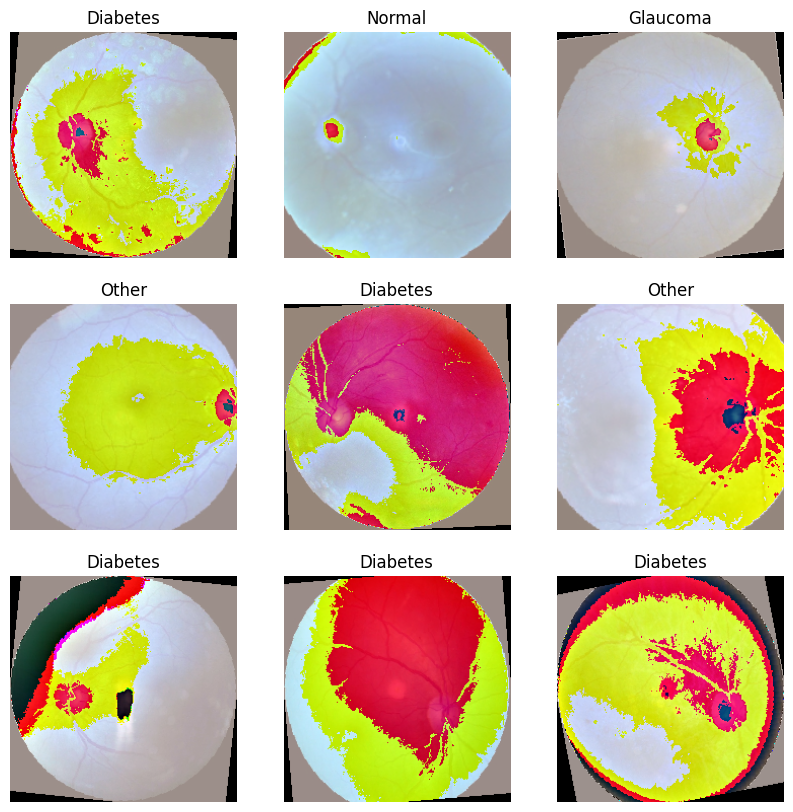

In [ ]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(32, 224, 224, 3)
(32, 8)


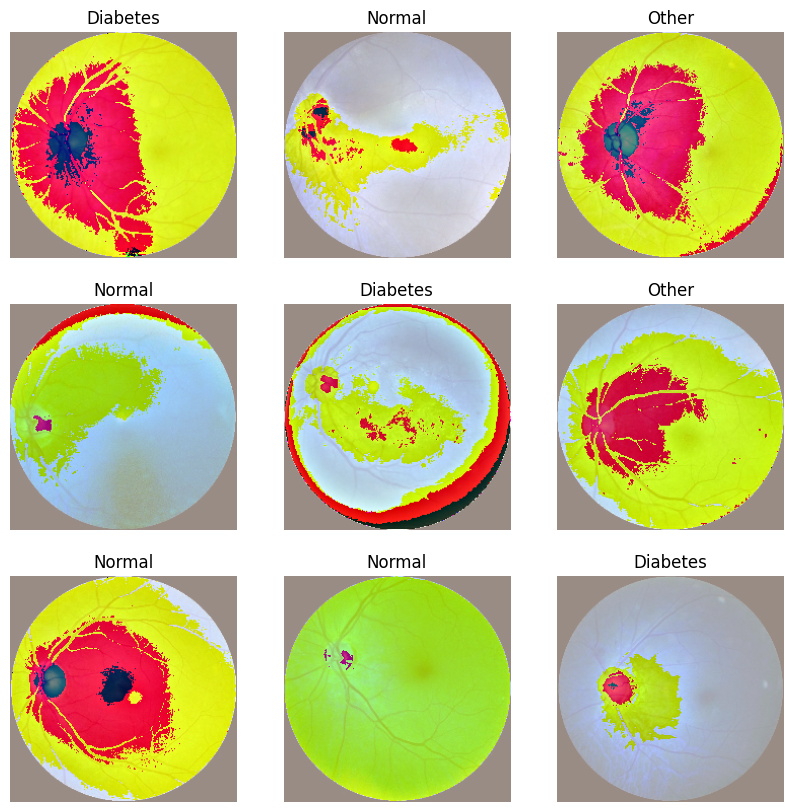

In [ ]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

In [ ]:
# Calculate class weights
def get_class_weights(labels):
    total_samples = len(labels)
    n_classes = len(labels[0])
    class_counts = np.zeros(n_classes)
    for label in labels:
        class_counts += label
    class_weights = total_samples / (n_classes * class_counts)
    return class_weights

# Get the labels from the training dataset
train_labels = []
for _, labels in train_ds:
    train_labels.append(labels.numpy())
train_labels = np.concatenate(train_labels)

# Calculate class weights
class_weights = get_class_weights(train_labels)
print("Class weights:", class_weights)

# Assuming class_weights is the array returned by your function
class_weights_array = get_class_weights(train_labels)

# Convert this array into a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class weights dictionary:", class_weights_dict)

Class weights: [0.27442133 0.49057882 3.01780303 2.77402507 2.94637574 6.425
 3.51899293 1.18134638]
Class weights dictionary: {0: 0.2744213281895839, 1: 0.49057881773399015, 2: 3.01780303030303, 3: 2.774025069637883, 4: 2.9463757396449703, 5: 6.425, 6: 3.518992932862191, 7: 1.1813463819691579}


# Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Setup callbacks
checkpoint = ModelCheckpoint(filepath='best_model', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


callbacks = [early_stopping, checkpoint, reduce_lr]

In [ ]:
from tensorflow.keras.layers import Dense, Dropout

pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 14848072 (56.64 MB)
Trainable params: 133384 (521.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


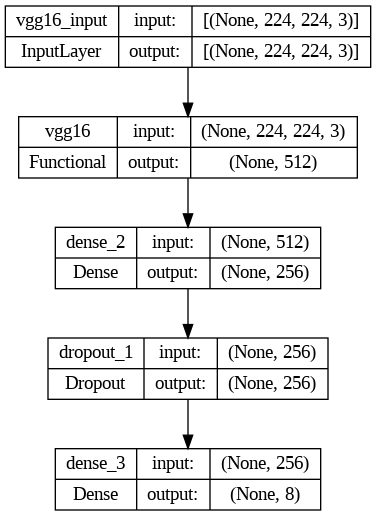

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
epochs = 80
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/80
249/249 [==============================] - ETA: 0s - loss: 2.9313 - accuracy: 0.3504
Epoch 1: val_loss improved from inf to 1.57816, saving model to best_model
249/249 [==============================] - 93s 212ms/step - loss: 2.9313 - accuracy: 0.3504 - val_loss: 1.5782 - val_accuracy: 0.4737 - lr: 1.0000e-04
Epoch 2/80
249/249 [==============================] - ETA: 0s - loss: 1.6920 - accuracy: 0.4253
Epoch 2: val_loss improved from 1.57816 to 1.42829, saving model to best_model
249/249 [==============================] - 74s 178ms/step - loss: 1.6920 - accuracy: 0.4253 - val_loss: 1.4283 - val_accuracy: 0.4892 - lr: 1.0000e-04
Epoch 3/80
249/249 [==============================] - ETA: 0s - loss: 1.5164 - accuracy: 0.4535
Epoch 3: val_loss improved from 1.42829 to 1.40245, saving model to best_model
249/249 [==============================] - 74s 176ms/step - loss: 1.5164 - accuracy: 0.4535 - val_loss: 1.4025 - val_accuracy: 0.5058 - lr: 1.0000e-04
Epoch 4/80
249/249 [======

# Evaluating Model
- Model Accuracy
- Model Loss


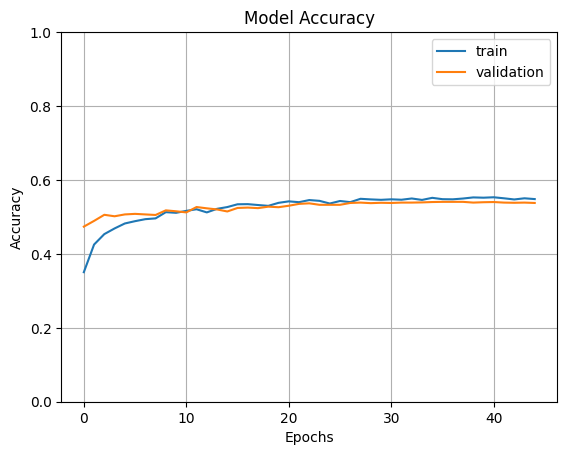

In [26]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

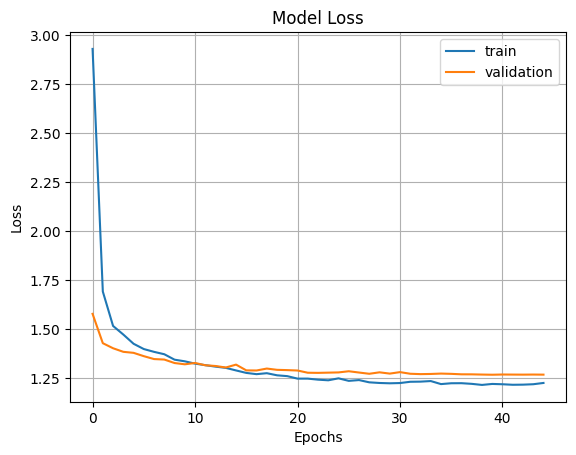

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Finetuning

In [37]:
for layer in pretrained_model.layers[-4:]:
    layer.trainable = True

# Recompile the model after making the layers trainable
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
epochs = 80
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/80
249/249 [==============================] - ETA: 0s - loss: 1.2224 - accuracy: 0.5511
Epoch 1: val_loss did not improve from 1.26720
249/249 [==============================] - 79s 185ms/step - loss: 1.2224 - accuracy: 0.5511 - val_loss: 1.2933 - val_accuracy: 0.5338 - lr: 1.0000e-05
Epoch 2/80
249/249 [==============================] - ETA: 0s - loss: 1.2191 - accuracy: 0.5488
Epoch 2: val_loss improved from 1.26720 to 1.26047, saving model to best_model
249/249 [==============================] - 76s 189ms/step - loss: 1.2191 - accuracy: 0.5488 - val_loss: 1.2605 - val_accuracy: 0.5403 - lr: 1.0000e-05
Epoch 3/80
249/249 [==============================] - ETA: 0s - loss: 1.1969 - accuracy: 0.5606
Epoch 3: val_loss improved from 1.26047 to 1.23549, saving model to best_model
249/249 [==============================] - 76s 189ms/step - loss: 1.1969 - accuracy: 0.5606 - val_loss: 1.2355 - val_accuracy: 0.5458 - lr: 1.0000e-05
Epoch 4/80
249/249 [==============================] - 

# Evaluating Model
- Model Accuracy
- Model Loss


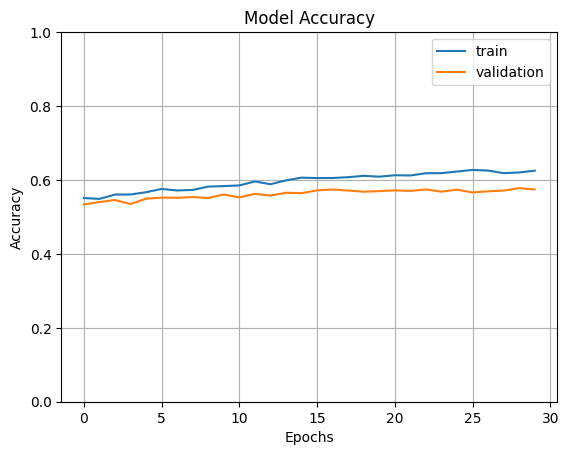

In [39]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

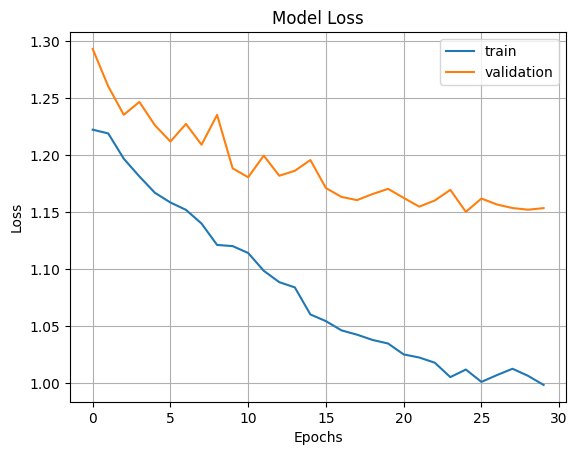

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions


In [41]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')

78/78 [==============================] - 11s 140ms/step - loss: 1.1559 - accuracy: 0.5762
Test accuracy: 57.62%


78/78 [==============================] - 11s 142ms/step - loss: 1.1559 - accuracy: 0.5762
Evaluation results: [1.1558852195739746, 0.5761828422546387]
78/78 [==============================] - 11s 135ms/step


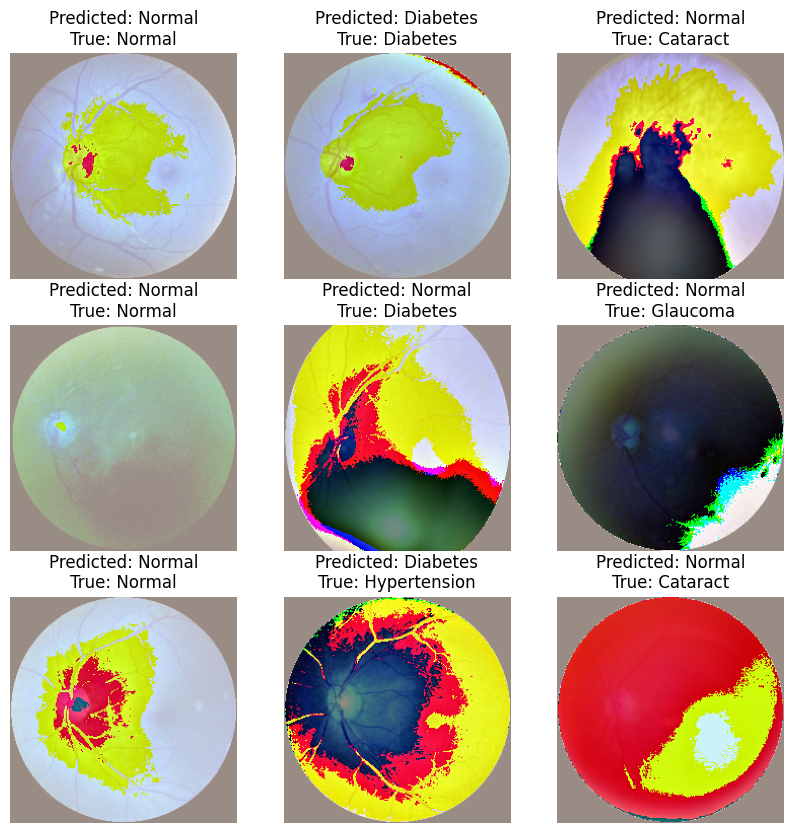

In [42]:
# Evaluate the model on the test dataset
evaluation_results =model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()

# Prediction Evaluation
- Classes normal, diabetes and others are the top 3 predicted classes, this suggests that the remaining classes are underrepresented hence the model is not using them to classify the test data.

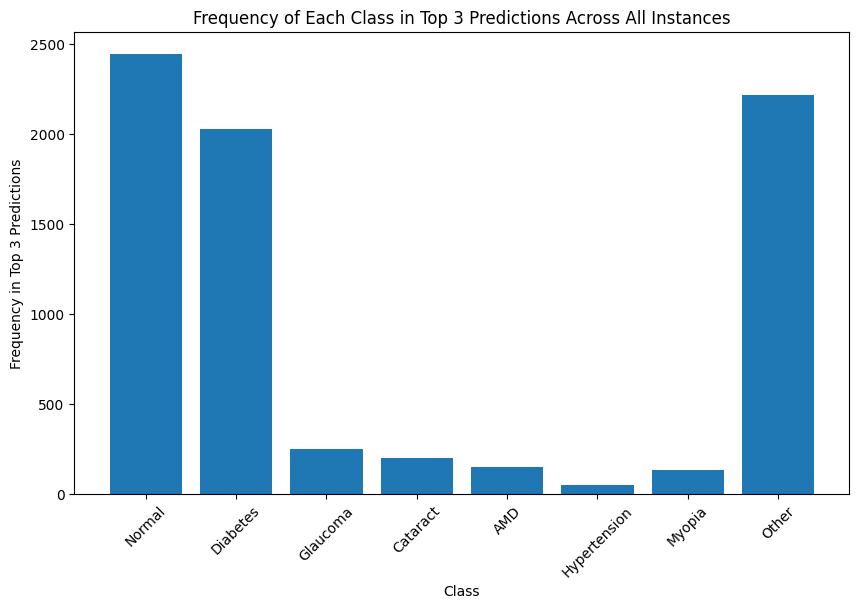

In [43]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [44]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report

In [45]:
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Unbatched label shape: (8,)
Shape of true_labels after vstack: (2494, 8)


In [46]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)

                precision    recall  f1-score   support

        Normal       0.54      0.88      0.67      1080
      Diabetes       0.62      0.42      0.50       633
      Glaucoma       0.58      0.22      0.32       113
      Cataract       0.72      0.65      0.68       118
           AMD       0.76      0.28      0.41        99
  Hypertension       0.75      0.05      0.10        56
        Myopia       0.87      0.80      0.83        97
Other diseases       0.30      0.03      0.05       298

      accuracy                           0.58      2494
     macro avg       0.64      0.42      0.45      2494
  weighted avg       0.57      0.58      0.52      2494



Balanced Accuracy Score

In [47]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.4176


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)


In [48]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8367


Confusion Matrix

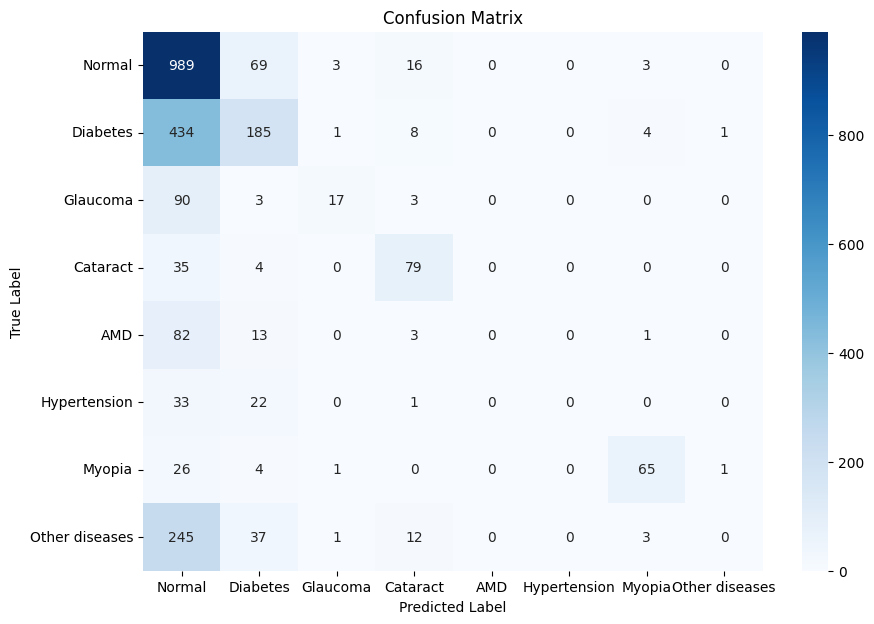

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Normalised Confusion Matrix

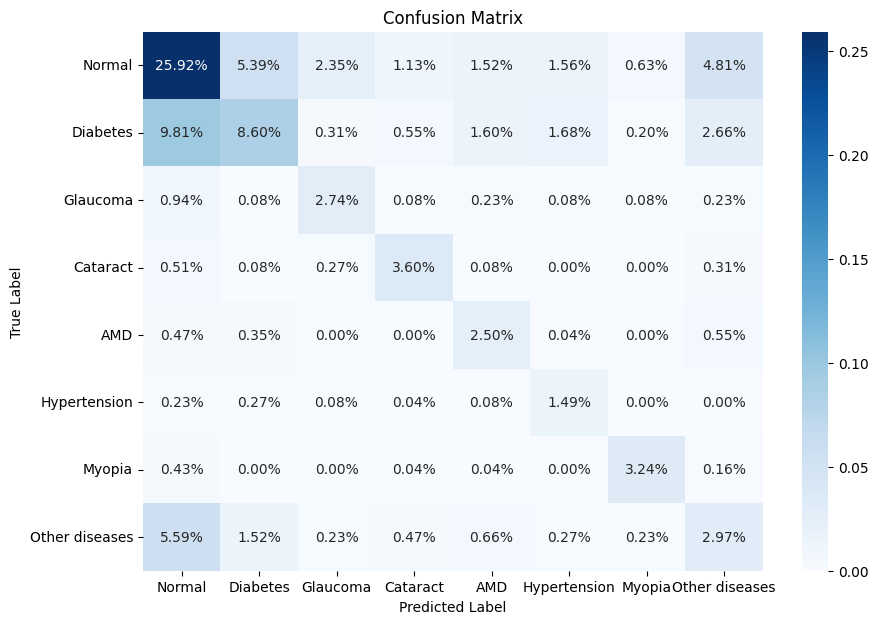

In [ ]:
# Calculate normalized confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum()

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Explainable AI
- SHAP, GradCAM, LIME